In [45]:
library(readr)
library(dplyr, warn=F)
library(ggplot2)
library(magrittr)

In [46]:
cols = list(
  cancer = '#F1A340',
  hema = '#F7F7F7',
  immune = '#998EC3',
  ms = '#423869'
)

In [47]:
prox_df = readr::read_tsv('data/proximities.tsv')
cat_cols = list(
  category = readr::col_factor(levels = c('Solid Cancer', 'Autoimmune', 'Hematologic Cancer'))
)
cat_df = readr::read_tsv('input/doid-categories.tsv', col_types = cat_cols)

prox_df = prox_df %>%
  dplyr::left_join(
    cat_df %>% dplyr::transmute(source_id = doid_code, source_category = category)
  ) %>%
  dplyr::left_join(
    cat_df %>% dplyr::transmute(target_id = doid_code, target_category = category)
  )

head(prox_df)

Joining by: "source_id"
Joining by: "target_id"


,source_id,source_name,target_id,target_name,proximity,source_category,target_category
1,DOID:10652,Alzheimer's disease,DOID:1936,atherosclerosis,0.186054,NA,NA
2,DOID:10652,Alzheimer's disease,DOID:14221,metabolic syndrome X,0.173963,NA,NA
3,DOID:10652,Alzheimer's disease,DOID:1107,esophageal carcinoma,0.076065,NA,Solid Cancer
4,DOID:10652,Alzheimer's disease,DOID:10871,age related macular degeneration,0.049695,NA,NA
5,DOID:10652,Alzheimer's disease,DOID:10286,prostate carcinoma,0.041593,NA,Solid Cancer
6,DOID:10652,Alzheimer's disease,DOID:10941,intracranial aneurysm,0.034034,NA,NA


In [48]:
wilcox_df = prox_df %>%
  dplyr::filter(source_category %in% c('Solid Cancer', 'Hematologic Cancer', 'Autoimmune')) %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Autoimmune')) %>%
  dplyr::group_by(source_category) %>%
  dplyr::do(wilcox.test(.$proximity ~ .$target_category) %$% dplyr::data_frame(statistic, p.value))

wilcox_df$p.value <- sprintf("p%%~~%%%.2e", wilcox_df$p.value)
wilcox_df$p.value <- sub('e', '%*%10^', wilcox_df$p.value)
wilcox_df$x <- Inf
wilcox_df$y <- Inf
wilcox_df

,source_category,statistic,p.value,x,y
1,Solid Cancer,3467,p%~~%2.25%*%10^-01,Inf,Inf
2,Autoimmune,10235,p%~~%1.51%*%10^-33,Inf,Inf
3,Hematologic Cancer,141,p%~~%3.14%*%10^-03,Inf,Inf


ERROR: Error in if (args[[1]]$name == "C_title" && !is.null(args[[2]])) {: missing value where TRUE/FALSE needed


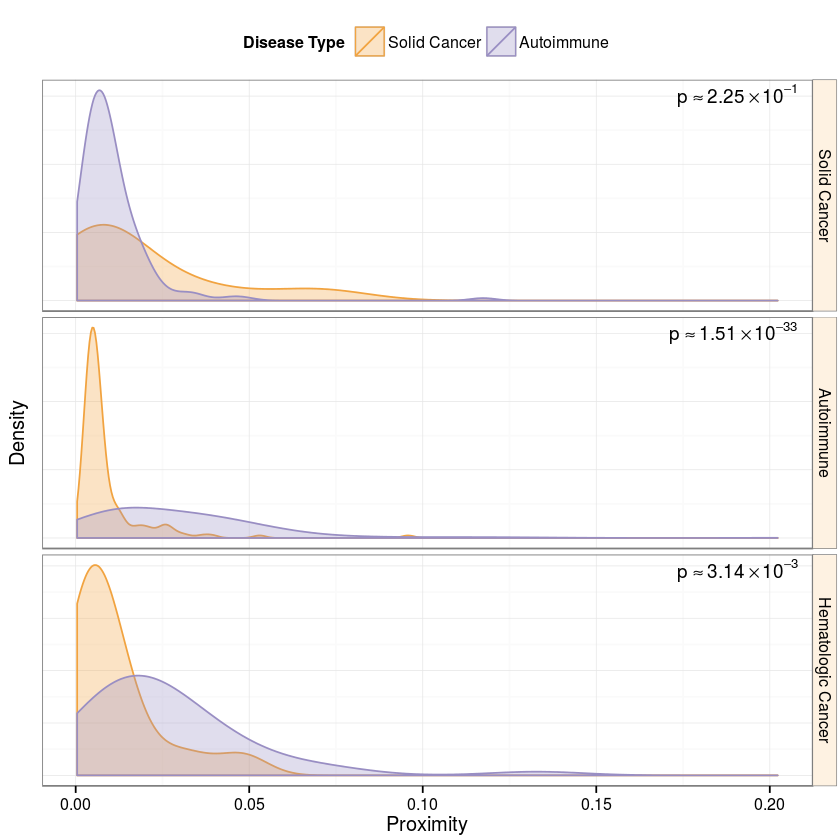

In [49]:
density.plot <- prox_df %>%
  dplyr::filter(source_category %in% c('Solid Cancer', 'Hematologic Cancer', 'Autoimmune')) %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Autoimmune')) %>%
  ggplot(aes(proximity, fill=target_category, color=target_category)) +
  geom_density(alpha=0.3, adjust=2) +
  facet_grid(source_category ~ ., scales='free_y') +
  theme_bw() +
  scale_fill_manual(values = c(cols$cancer, cols$immune)) +
  scale_color_manual(values = c(cols$cancer, cols$immune)) +
  xlab('Proximity') + ylab('Density') +
  guides(fill=guide_legend('Disease Type'), color=guide_legend('Disease Type')) +
  geom_text(data=wilcox_df, aes(x=x, y=y, label=p.value, fill=NULL, color=NULL), 
    parse=TRUE, hjust=1.12, vjust=1.2, size=4, show_guide=FALSE) +
  theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), legend.position='top') +
  ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2')) +
  theme(plot.margin = grid::unit(c(2, 2, 2, 2), 'points'))

density.plot

In [50]:
prox_df %>%
  dplyr::filter(source_name == 'multiple sclerosis')

,source_id,source_name,target_id,target_name,proximity,source_category,target_category
1,DOID:2377,multiple sclerosis,DOID:10608,celiac disease,0.056865,Autoimmune,Autoimmune
2,DOID:2377,multiple sclerosis,DOID:2841,asthma,0.055679,Autoimmune,Autoimmune
3,DOID:2377,multiple sclerosis,DOID:8778,Crohn's disease,0.051225,Autoimmune,Autoimmune
4,DOID:2377,multiple sclerosis,DOID:9744,type 1 diabetes mellitus,0.049571,Autoimmune,Autoimmune
5,DOID:2377,multiple sclerosis,DOID:8577,ulcerative colitis,0.046035,Autoimmune,Autoimmune
6,DOID:2377,multiple sclerosis,DOID:4481,allergic rhinitis,0.043658,Autoimmune,Autoimmune
7,DOID:2377,multiple sclerosis,DOID:7148,rheumatoid arthritis,0.042828,Autoimmune,Autoimmune
8,DOID:2377,multiple sclerosis,DOID:12236,primary biliary cirrhosis,0.0416,Autoimmune,Autoimmune
9,DOID:2377,multiple sclerosis,DOID:9074,systemic lupus erythematosus,0.034554,Autoimmune,Autoimmune
10,DOID:2377,multiple sclerosis,DOID:8893,psoriasis,0.031861,Autoimmune,Autoimmune
